# LDA
- LDA, or Latent Dirichlet Allocation, is a statistical model used in natural language processing and machine learning for topic modeling. It is a generative probabilistic model that allows you to discover hidden topics in a large corpus of text data.

- The importance of LDA is that it allows you to identify the latent topics within a document or a collection of documents. This can be very useful in a number of applications such as content analysis, sentiment analysis, text classification, and information retrieval.

- The performance of LDA is typically evaluated using a variety of measures, such as perplexity, coherence, and topic diversity. Perplexity measures how well the model can predict new unseen documents, while coherence measures how well the topics generated by the model are interpretable and coherent. Topic diversity measures how different the topics are from each other.

- Interpreting the output of an LDA model involves looking at the most probable words associated with each topic and interpreting them. The topics generated by the model can then be labeled based on these words, and the results can be used to gain insights into the underlying themes in the corpus of text data.

In [1]:
! pip install --quiet --upgrade nltk gensim wordcloud > /dev/null

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('all', quiet=True)

True

In [3]:
# importing the libraries
import pandas as pd
import pickle
import re
import string
import numpy as np
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")


In [4]:
import os

# Identify the working directory and data files
working_directory = "35-LDA_and_NMF_finalized"

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

In [5]:
# loading the data
df = pd.read_pickle("./21-Preprocess-Combined-Data-v2/dataframe.pickle")

In [6]:
# Topics range
min_topics = 1
max_topics = 25

# The number of top words per topic
num_top_words = 10

# Initial random state
random_state = 42

# A row to use for verification of processing
verification_row = 9

In [7]:
df.head()

,ROW_ID,FOI_TEXT,DEVICE_PROBLEM_CODE,DEVICE_PROBLEM_TEXT,GENERIC_NAME,DEVICE_REPORT_PRODUCT_CODE,UDI-DI,UDI-PUBLIC,DATE_OF_EVENT,REPORTER_OCCUPATION_CODE,REPORT_DATE,EVENT_LOCATION,SOURCE_TYPE,TOKENIZED_TEXT,NOPUNCT_TEXT,NOSTOPWORDS_TEXT,NODIGITS_TEXT,POS_TEXT,LEMMATIZED_TEXT,STEMMED_TEXT
0,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,,,07/30/2020,000,,I,CONSUMER,"[it, was, reported, that, the, transmitter, lo...","[it, was, reported, that, the, transmitter, lo...","[reported, transmitter, lost, connection, pump...","[reported, transmitter, lost, connection, pump...","[(reported, VBN), (transmitter, NN), (lost, VB...","[report, transmitter, lose, connection, pump, ...","[report, transmitt, lost, connect, pump, great..."
1,1426265,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,06/05/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, produ...","[report, signal, loss, one, hour, occur, produ..."
2,2609625,IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...,1435,No Device Output,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,10/05/2020,000,,I,CONSUMER,"[it, was, reported, that, transmitter, failed,...","[it, was, reported, that, transmitter, failed,...","[reported, transmitter, failed, error, occurre...","[reported, transmitter, failed, error, occurre...","[(reported, VBN), (transmitter, NN), (failed, ...","[report, transmitter, fail, error, occur, data...","[report, transmitt, fail, error, occur, data, ..."
3,2813837,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,10/23/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, revie...","[report, signal, loss, one, hour, occur, revie..."
4,1337517,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,05/25/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, produ...","[report, signal, loss, one, hour, occur, produ..."


In [8]:
# create a DataFrame for the sentences
sentences_df = pd.DataFrame(
    columns=[
        'SENTENCE_ID',
        'SENTENCE', 
        'ROW_ID', 
        'FOI_TEXT', 
        'DEVICE_PROBLEM_CODE',
        'DEVICE_PROBLEM_TEXT'
    ]
)

# Iterate over every row in the FOI_TEXT DataFrame
# and create a new dataframe with a row for each sentence.
# Each row will have a sentence, the orginal ROW_ID, and the
# FOI_TEXT that it came from along with the DEVICE_PROBLEM_CODE and
# DEVICE_PROBLEM_TEXT from the orginal FOI_TEXT
sentence_counter = 0

for index, row in df.iterrows():
    for sentence in nltk.sent_tokenize(row['FOI_TEXT']):
        sentence_data = {
            'SENTENCE': sentence,
            'SENTENCE_ID': sentence_counter,
            'ROW_ID': row['ROW_ID'], 
            'FOI_TEXT': row['FOI_TEXT'], 
            'DEVICE_PROBLEM_CODE': row['DEVICE_PROBLEM_CODE'],
            'DEVICE_PROBLEM_TEXT': row['DEVICE_PROBLEM_TEXT']
        }
        sentences_df = sentences_df.append(sentence_data, ignore_index=True)
        sentence_counter = sentence_counter + 1        

In [9]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

punctuations = set(string.punctuation)

def process_sentence(sentence):
    # Lowercase the sentence
    sentence = sentence.lower()

    # Remove any words that start with a digit
    sentence = re.sub(r'\b\d\w*\b', '', sentence)

    # Remove punctuation
    sentence_tokens = sentence.split()
    sentence_tokens = [token.translate(str.maketrans("", "", string.punctuation)) for token in sentence_tokens]

    # Remove stopwords
    sentence_tokens = [token for token in sentence_tokens if token not in stop_words]
    
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in sentence_tokens]
    
    # Rebuild the sentence
    sentence = ' '.join(lemmatized_tokens)

    return sentence

sentences_df['PROCESSED_SENTENCE'] = sentences_df['SENTENCE'].apply(process_sentence)

In [10]:
sentences_df['PROCESSED_SENTENCE']

0        report transmitter lose connection pump greate...
1            transmitter ultimately regain connection pump
2           additional patient event information available
3                        report signal loss one hour occur
4                          product data provide evaluation
                               ...                        
25681                    report signal loss one hour occur
25682                              data receive evaluation
25683    however allege product present within investig...
25684    confirmation allegation probable cause could d...
25685                   injury medical intervention report
Name: PROCESSED_SENTENCE, Length: 25686, dtype: object

In [11]:
# Tokenizing the text data in Processed_sentences
processed_docs = sentences_df['PROCESSED_SENTENCE'].apply(lambda x: word_tokenize(x))

In [12]:
# Removing the stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
processed_docs = [[word for word in doc if word.lower() not in stop_words] for doc in processed_docs]

In [13]:
# Creating a dictionary of words and their frequency
dictionary = corpora.Dictionary(processed_docs)

# Filtering out words that appear in less than 5 documents, and more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Creating bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## Create a Word Cloud

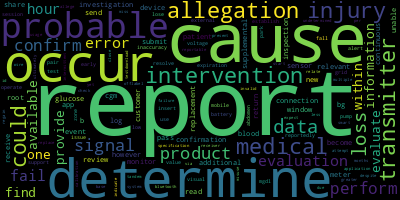

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud

wordcloud_target = {dictionary[i]: freq for i, freq in dictionary.dfs.items()}

# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white", 
    max_words=5000, 
    contour_width=3, 
    contour_color='steelblue', 
    width=1920, 
    height=1080)

# Generate a word cloud
wordcloud = WordCloud().generate_from_frequencies(wordcloud_target)

# Visualize the word cloud
wordcloud.to_image()

In [15]:
# Building LDA model with varying number of topics
min_topics = 2
max_topics = 25
step_size = 1

coherence_scores = []
coherence_lda_collection = []
lda_model_collection = []
coherence_model_collection = []

for num_topics in range(min_topics, max_topics+step_size, step_size):

    lda_model_collection.append(gensim.models.LdaModel(
        bow_corpus, 
        num_topics=num_topics,
        random_state=21, 
        id2word=dictionary, 
        passes=10
    ))
    
    coherence_model_collection.append(CoherenceModel(
        model=lda_model_collection[num_topics-2], 
        texts=processed_docs, 
        dictionary=dictionary, 
        coherence='c_v'
    ))
        
    coherence_scores.append(coherence_model_collection[num_topics-2].get_coherence())
    
    print(f"Number of topics: {num_topics}, Coherence Score: {coherence_scores[num_topics-2]}")

# Creating DataFrame of number of topics and corresponding coherence score
df_coherence = pd.DataFrame(
    {'num_topics': range(min_topics, max_topics+step_size, step_size), 
     'coherence_score': coherence_scores}
)

Number of topics: 2, Coherence Score: 0.37869444097212146
Number of topics: 3, Coherence Score: 0.36481419247884395
Number of topics: 4, Coherence Score: 0.36254280705967934
Number of topics: 5, Coherence Score: 0.419830469043294
Number of topics: 6, Coherence Score: 0.3624730874266968
Number of topics: 7, Coherence Score: 0.366491019396236
Number of topics: 8, Coherence Score: 0.3950949826346144
Number of topics: 9, Coherence Score: 0.38604301912839334
Number of topics: 10, Coherence Score: 0.40883202939020924
Number of topics: 11, Coherence Score: 0.39140053720401313
Number of topics: 12, Coherence Score: 0.3890533950277015
Number of topics: 13, Coherence Score: 0.39241531814233066
Number of topics: 14, Coherence Score: 0.3939643356246264
Number of topics: 15, Coherence Score: 0.39517441453641206
Number of topics: 16, Coherence Score: 0.3850660406493358
Number of topics: 17, Coherence Score: 0.3889509211928137
Number of topics: 18, Coherence Score: 0.3802744312290886
Number of topics

In [16]:
df_coherence 

,num_topics,coherence_score
0,2,0.378694
1,3,0.364814
2,4,0.362543
3,5,0.419830
4,6,0.362473
5,7,0.366491
6,8,0.395095
7,9,0.386043
8,10,0.408832
9,11,0.391401


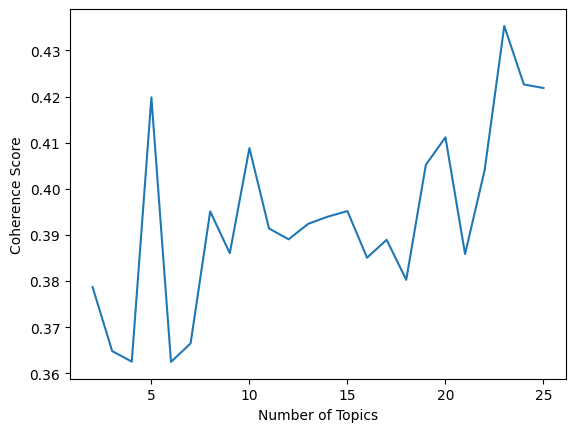

In [29]:
# Plotting the coherence score for each number of topics
x = range(min_topics, max_topics+step_size, step_size)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

# Analysis with "num_topics = 18"

In [30]:
# Choose the optimal number of topics
num_topics = 18

# Use the desired models from their respective collections
# "min_topics = 2" so the first model in the collection is 0
# the target model will be located in slot "num_topics - 2"
lda_model = lda_model_collection[num_topics - 2]

coherence_model_lda = coherence_model_collection[num_topics - 2]

coherence_lda = coherence_model_lda.get_coherence()

# Save the LDA model as a pickle file
with open(f"{working_directory}/lda_model_{num_topics}_topics.pickle", "wb") as f:
    pickle.dump(lda_model, f)

# Extract the top 10 words for each topic
top_words = lda_model.print_topics(num_topics=num_topics, num_words=10)

In [31]:
top_words

[(0,
  '0.134*"connection" + 0.121*"report" + 0.091*"pump" + 0.082*"greater" + 0.082*"hour" + 0.076*"loss" + 0.072*"mobile" + 0.058*"determine" + 0.057*"application" + 0.056*"transmitter"'),
 (1,
  '0.191*"device" + 0.093*"however" + 0.069*"operate" + 0.059*"within" + 0.047*"receive" + 0.047*"support" + 0.042*"specification" + 0.041*"investigation" + 0.038*"data" + 0.027*"return"'),
 (2,
  '0.230*"data" + 0.226*"evaluation" + 0.223*"product" + 0.201*"provide" + 0.029*"system" + 0.019*"receive" + 0.016*"smart" + 0.015*"indicate" + 0.013*"usage" + 0.013*"offlabel"'),
 (3,
  '0.104*"within" + 0.093*"find" + 0.091*"investigation" + 0.088*"review" + 0.087*"perform" + 0.086*"log" + 0.085*"share" + 0.085*"window" + 0.079*"loss" + 0.057*"signal"'),
 (4,
  '0.193*"b" + 0.188*"sensor" + 0.165*"insert" + 0.116*"abdomen" + 0.063*"use" + 0.048*"less" + 0.046*"transmitter" + 0.044*"months" + 0.033*"device" + 0.030*"usage"'),
 (5,
  '0.258*"perform" + 0.194*"pass" + 0.148*"inspection" + 0.148*"visual

In [44]:
topics_with_scores_df = pd.DataFrame()

for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    # creating a list of tuples containing the top 10 words and their probabilities for the topic
    top_words = [(word, round(prob, 4)) for word, prob in topic]
    
    # create a new dictionary to store the topic number and the top words with their probabilities
    row_dict = {'Topic': str(int(idx+1))}
    
    for i, (word, prob) in enumerate(top_words):
        row_dict[f"Word {i+1}"] = word
        row_dict[f"Weight {i+1}"] = str(round(prob, 4))

    # adding the topic and top words to the dataframe
    topics_with_scores_df = topics_with_scores_df.append(row_dict, ignore_index=True)
    
topics_with_scores_df.to_pickle(f"{working_directory}/lda_topics_with_scores_df_{num_topics}_topics.pickle")
topics_with_scores_df.to_csv(f"{working_directory}/lda_topics_with_scores_df_{num_topics}_topics.csv", index=False)

with pd.option_context('display.max_colwidth', None):
    display(topics_with_scores_df)

,Topic,Word 1,Weight 1,Word 2,Weight 2,Word 3,Weight 3,Word 4,Weight 4,Word 5,...,Word 6,Weight 6,Word 7,Weight 7,Word 8,Weight 8,Word 9,Weight 9,Word 10,Weight 10
0,1,connection,0.1335,report,0.1211,pump,0.0914,greater,0.082,hour,...,loss,0.0762,mobile,0.0721,determine,0.058,application,0.0569,transmitter,0.0556
1,2,device,0.1906,however,0.0926,operate,0.0693,within,0.0591,receive,...,support,0.0466,specification,0.0415,investigation,0.0405,data,0.0384,return,0.0271
2,3,data,0.2299,evaluation,0.226,product,0.2228,provide,0.2011,system,...,receive,0.0192,smart,0.0161,indicate,0.0146,usage,0.0125,offlabel,0.0125
3,4,within,0.1038,find,0.0934,investigation,0.0912,review,0.0879,perform,...,log,0.0864,share,0.0848,window,0.0846,loss,0.0792,signal,0.0568
4,5,b,0.1931,sensor,0.1884,insert,0.1654,abdomen,0.1157,use,...,less,0.0484,transmitter,0.0462,months,0.0439,device,0.0327,usage,0.0304
5,6,perform,0.2576,pass,0.1942,inspection,0.148,visual,0.1478,pair,...,testdownload,0.0363,bluetooth,0.0298,follow,0.02,b,0.0195,device,0.0122
6,7,determine,0.2129,cause,0.2099,could,0.1888,probable,0.1857,allegation,...,confirmation,0.0716,root,0.0227,via,0.0082,close,0.0043,mobile,0.0041
7,8,sensor,0.1607,session,0.1565,multiple,0.1042,attempt,0.0881,unable,...,find,0.0832,despite,0.0771,base,0.0459,reportable,0.0448,event,0.0394
8,9,transmitter,0.1973,fail,0.1702,report,0.1678,error,0.1661,occur,...,customer,0.0507,send,0.0362,replacement,0.0361,sensor,0.015,receive,0.0121
9,10,return,0.1456,product,0.1426,evaluation,0.1419,issue,0.0761,replace,...,transmitter,0.0485,resolve,0.0476,customer,0.0428,id,0.0364,invalid,0.0326


# NMF
- NMF (Non-negative Matrix Factorization) is a matrix factorization technique commonly used for unsupervised learning in data science and machine learning. NMF decomposes a non-negative matrix into two non-negative matrices: a basis matrix and a coefficient matrix. The basis matrix represents the fundamental features or patterns in the data, while the coefficient matrix represents the weights of those features for each observation.

- NMF is important because it can be used for dimensionality reduction, feature extraction, and clustering, among other tasks. It is especially useful when dealing with high-dimensional data or data with sparse features. For example, it has been successfully applied in areas such as image processing, text mining, and bioinformatics.

- Performance of NMF is typically evaluated using a metric such as reconstruction error or sparsity. Reconstruction error measures how well the original matrix can be approximated by the product of the basis and coefficient matrices. Sparsity measures the degree to which the basis and coefficient matrices contain mostly zeros. A good NMF model will have a low reconstruction error and high sparsity.

- Interpreting the results of NMF involves examining the basis matrix to understand the fundamental features or patterns in the data. Each row of the basis matrix corresponds to a feature or pattern, and the columns correspond to the original dimensions or variables of the data. The coefficient matrix can be used to understand how strongly each observation is associated with each feature or pattern.


# My concern with the NMF model is that the topic’s “top 10-word” weights add to a number greater than 1. From my research, I believe the weights should add to one.

- If the top word weights for a given topic add up to a number greater than 1, it may be a result of normalization not being applied properly. One common normalization technique for NMF is to divide each row of the coefficient matrix (which represents the weight of each topic for each document) by the sum of its elements. This ensures that the weights for each document sum to 1.

- To address the issue of the top word weights for a given topic summing to a number greater than 1, you could try normalizing the weights for each topic to ensure that they sum to 1. One way to do this is to divide each weight by the sum of all the weights for that topic.

- The NMF weights for each topic are also added to a dataframe nmf_weights_df, which has one row for each topic and one column for each word in the vocabulary. Each element in the dataframe represents the weight of that word in that topic. The weights are normalized so that they sum to 1 for each topic.

In [37]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

In [38]:
# Defining the number of topics to try
min_topics = 1
max_topics = 25
num_top_words = 10
random_state = 42


In [39]:
# Converting the preprocessed sentences to a list
processed_sentences = sentences_df['PROCESSED_SENTENCE'].tolist()

# Creating a TfidfVectorizer object
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_sentences = vectorizer.fit_transform(processed_sentences)

# Creating an empty dataframe to hold the NMF weights
nmf_weights_df = pd.DataFrame()

# Creating an empty dataframe to hold coherence scores
coherence_scores_df = pd.DataFrame(columns=['k', 'Coherence Score'])

for k in range(min_topics, max_topics + 1):
    nmf_model = NMF(
        n_components=k, 
        random_state=random_state, 
        init='nndsvda'
    )
    
    nmf = nmf_model.fit_transform(vectorized_sentences)
    
    vocab = vectorizer.get_feature_names_out()
    
    topics = []
    
    for topic_index, topic in enumerate(nmf_model.components_):
        top_words = [vocab[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(top_words)
        
        # Adding the NMF weights to the dataframe
        nmf_weights = pd.DataFrame(topic).T.add_prefix('Topic_')
        nmf_weights['k'] = k
        nmf_weights_df = nmf_weights_df.append(nmf_weights)
        
    # Normalizing the NMF weights so they sum to 1
    nmf_weights_df.iloc[:, :-1] = nmf_weights_df.iloc[:, :-1].div(
        nmf_weights_df.iloc[:, :-1].sum(axis=1), 
        axis=0
    )
    
    # splitting each sentence into a list of words
    texts = sentences_df['PROCESSED_SENTENCE'].apply(lambda x: nltk.word_tokenize(x)).tolist()
    
    # Creating a dictionary from the words
    dictionary = corpora.Dictionary(texts)
    
    # Creating a bag-of-words representation of the corpus
    corpus = [dictionary.doc2bow(word) for word in texts]
    
    coherence_model = CoherenceModel(
                        topics=topics, 
                        texts=texts, 
                        dictionary=dictionary, 
                        coherence='c_v'
                      )
    
    coherence_score = coherence_model.get_coherence()

    coherence_scores_df = coherence_scores_df.append(
        pd.Series(
            [k, coherence_score], 
            index=['k', 'Coherence Score']
        ), 
        ignore_index=True
    )

In [40]:
# Creating a dataframe of the top 10 words for each topic
top_words_df = pd.DataFrame(topics, columns=[f'word_{i}' for i in range(num_top_words)])
top_words_df

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
0,injury,intervention,medical,report,adverse,occur,impact,expiration,alert,early
1,probable,determine,cause,data,allegation,mobile,defective,potential,signal,loss
2,hour,signal,loss,occur,report,application,relate,mobile,expiration,early
3,confirm,allegation,data,undetermined,message,early,addition,expiration,greater,problem
4,provide,evaluation,data,product,investigation,receive,pending,complete,support,session
5,fail,error,transmitter,occur,report,customer,receive,use,reportable,base
6,review,log,share,window,investigation,perform,loss,signal,connection,allege
7,additional,patient,event,available,information,close,mobile,misuse,reportable,base
8,evaluate,data,product,undetermined,investigation,session,support,greater,message,complete
9,supplemental,submit,relevant,new,available,information,report,perform,device,evaluation


In [41]:
# Joining the coherence scores dataframe with the top words dataframe
coherence_scores_df = coherence_scores_df.merge(top_words_df, left_index=True, right_index=True)
coherence_scores_df

,k,Coherence Score,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
0,1.0,0.237714,injury,intervention,medical,report,adverse,occur,impact,expiration,alert,early
1,2.0,0.295871,probable,determine,cause,data,allegation,mobile,defective,potential,signal,loss
2,3.0,0.365870,hour,signal,loss,occur,report,application,relate,mobile,expiration,early
3,4.0,0.353840,confirm,allegation,data,undetermined,message,early,addition,expiration,greater,problem
4,5.0,0.362692,provide,evaluation,data,product,investigation,receive,pending,complete,support,session
5,6.0,0.394495,fail,error,transmitter,occur,report,customer,receive,use,reportable,base
6,7.0,0.424196,review,log,share,window,investigation,perform,loss,signal,connection,allege
7,8.0,0.420263,additional,patient,event,available,information,close,mobile,misuse,reportable,base
8,9.0,0.407765,evaluate,data,product,undetermined,investigation,session,support,greater,message,complete
9,10.0,0.396091,supplemental,submit,relevant,new,available,information,report,perform,device,evaluation


In [42]:
nmf_weights_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_812,Topic_813,Topic_814,Topic_815,Topic_816,Topic_817,Topic_818,Topic_819,Topic_820,k
0,2.900162e-07,0.000027,5.606506e-09,0.000002,5.026840e-07,3.717690e-06,2.454243e-07,0.000071,1.770630e-08,0.000002,...,0.000425,0.000055,1.471815e-06,2.694607e-06,1.941491e-07,3.074581e-08,8.039155e-09,1.459318e-06,0.000588,1
0,2.889639e-07,0.000026,4.265018e-09,0.000000,1.617504e-07,3.757521e-06,2.270804e-07,0.000071,1.710983e-08,0.000002,...,0.000428,0.000055,1.478483e-06,2.708966e-06,1.844629e-07,2.989320e-08,8.048529e-09,1.445861e-06,0.000590,2
0,8.946238e-08,0.000027,4.444425e-08,0.000282,2.081707e-05,6.447235e-10,6.197463e-07,0.000016,2.363676e-08,0.000002,...,0.000032,0.000011,2.633276e-07,6.684061e-07,3.547672e-07,3.446561e-08,1.589550e-09,6.316192e-07,0.000130,2
0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,3.644672e-06,2.660528e-08,0.000062,4.221765e-09,0.000001,...,0.000206,0.000020,1.505645e-06,3.309152e-06,2.303632e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000328,3
0,0.000000e+00,0.000019,4.457408e-08,0.000296,2.166158e-05,0.000000e+00,6.074883e-07,0.000012,2.111648e-08,0.000002,...,0.000000,0.000002,1.802506e-07,6.899900e-07,3.228174e-07,2.517076e-08,0.000000e+00,0.000000e+00,0.000046,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,7.808211e-06,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,5.214225e-06,0.000000e+00,0.000000e+00,0.000000e+00,2.936291e-06,1.117609e-03,0.000000,25
0,7.260919e-06,0.000000,0.000000e+00,0.001944,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000302,1.592893e-05,6.091541e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25
0,2.071132e-06,0.000000,1.492478e-06,0.000000,4.590846e-06,0.000000e+00,0.000000e+00,0.001438,5.686227e-05,0.000000,...,0.000000,0.000000,3.751791e-05,0.000000e+00,7.993892e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25
0,0.000000e+00,0.000000,1.577787e-07,0.000000,2.702875e-05,0.000000e+00,0.000000e+00,0.000805,2.859387e-05,0.000000,...,0.000000,0.000000,9.007980e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,25


In [43]:
# Checking if the sum of all coefficients of a NMF model for each topic sums to greater than 1 or not
print(np.allclose(nmf_weights_df.iloc[:, :-1].sum(axis=1), 1.0))

True
